# Generate T, S - profile file for MOM6 initialization
Values are defined on a z-grid, and output both as a single profile and 3D array corresponding to the model grid

In [12]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from cycler import cycler
from scipy.optimize import curve_fit

In [2]:
# Specify geometry of vertical grid
# (based on MOM6 input parameters)

NK = 20
MAXIMUM_DEPTH = 4000
MINIMUM_DEPTH = 0

# Resolve vertical grid
# Uniform
Z = np.linspace(MINIMUM_DEPTH,MAXIMUM_DEPTH,NK)

# Specify geometry of horizontal grid
# (for extension of profile to 3D grid)

# Latitude and longitude
SOUTHLAT=-60.0
LENLAT=30.0
WESTLON=0.0
LENLON=100.0

# Number of grid cells
NI=100
NJ=20

# Grid point positions (tracer point)
X=np.linspace(WESTLON,WESTLON+LENLON,NI+1)
X1d=(X[1:] + X[:-1]) / 2
Y=np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,NJ+1)
Y1d=(Y[1:] + Y[:-1]) / 2

# Array of grid point positions
X,Y=np.meshgrid(X1d,Y1d)

# Linear
Linear profile of temperature and salinity with depth

In [3]:
# Assign temperature and salinity to each depth level

# Linear
T_SURFACE = 10
T_BOTTOM = 0
S_SURFACE = 34
S_BOTTOM = 35

PTEMP = np.linspace(T_SURFACE,T_BOTTOM,NK)
SALT = np.linspace(S_SURFACE,S_BOTTOM,NK)

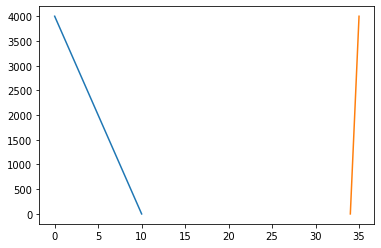

In [4]:
plt.plot(PTEMP,Z)
plt.plot(SALT,Z)

In [5]:
# Save to initialisation file
rootdir = '/work/gam/MOM6/initialization/'
config = 'channel'
filename = 'ts_uniform_1deg.nc'

with Dataset(rootdir+config+'/'+filename,'w') as d:
    d.createDimension('NK',NK)
    d.createVariable('Z','f8',('NK'))[:]=Z
    d.createVariable('PTEMP','f8',('NK'))[:]=PTEMP
    d.createVariable('SALT','f8',('NK'))[:]=SALT

PermissionError: [Errno 13] Permission denied: b'/work/gam/MOM6/initialization/channel/ts_uniform_1deg.nc'

# WOA
Load World Ocean Atlas data, take zonal means over domain

In [6]:
# ___ IMPORT DATA ___ #

# Import WOA .nc files
rootdir = '/work/gam/WOA/'
filename_SALT = 'woa18_decav_s00_01.nc'
filename_PTEMP = 'woa18_decav_t00_01.nc'

SALT_WOA = xr.open_dataset(rootdir+filename_SALT,decode_times=False)
PTEMP_WOA = xr.open_dataset(rootdir+filename_PTEMP,decode_times=False)

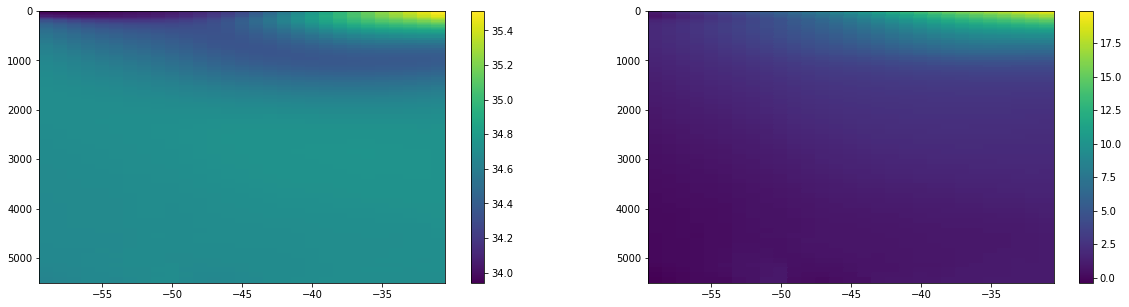

In [7]:
# ___ ZONAL MEAN SECTION IN SOUTHERN OCEAN ___ #

# Select Southern Ocean subset of WOA climatological data and take zonal average
SALT_WOA_SO_xmean = SALT_WOA.s_an.sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT),time=4326).mean(dim='lon')
PTEMP_WOA_SO_xmean = PTEMP_WOA.t_an.sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT),time=4326).mean(dim='lon')

# Plot resulting zonal mean sections
fig,ax = plt.subplots(figsize=(20,5),ncols=2)
im = ax[0].pcolormesh(SALT_WOA_SO_xmean.lat,SALT_WOA_SO_xmean.depth,SALT_WOA_SO_xmean)
cbar=plt.colorbar(im,ax=ax[0])
im = ax[1].pcolormesh(PTEMP_WOA_SO_xmean.lat,PTEMP_WOA_SO_xmean.depth,PTEMP_WOA_SO_xmean)
cbar=plt.colorbar(im,ax=ax[1])
ax[0].invert_yaxis()
ax[1].invert_yaxis()

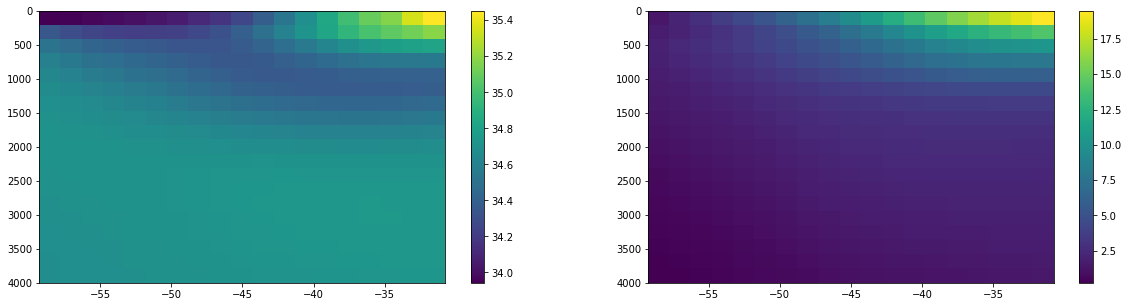

In [8]:
# ___ INTERPOLATE ONTO MODEL GRID ___ #

# Interpolate onto latitude-z* grid of model configuration
SALT_WOA_SO_xmean_interp = SALT_WOA_SO_xmean.interp(lat=Y1d,depth=Z,)
PTEMP_WOA_SO_xmean_interp = PTEMP_WOA_SO_xmean.interp(lat=Y1d,depth=Z,)

# Plot interpolated zonal mean sections
fig,ax = plt.subplots(figsize=(20,5),ncols=2)
im = ax[0].pcolormesh(SALT_WOA_SO_xmean_interp.lat,SALT_WOA_SO_xmean_interp.depth,SALT_WOA_SO_xmean_interp)
cbar=plt.colorbar(im,ax=ax[0])
im = ax[1].pcolormesh(PTEMP_WOA_SO_xmean_interp.lat,PTEMP_WOA_SO_xmean_interp.depth,PTEMP_WOA_SO_xmean_interp)
cbar=plt.colorbar(im,ax=ax[1])
ax[0].invert_yaxis()
ax[1].invert_yaxis()

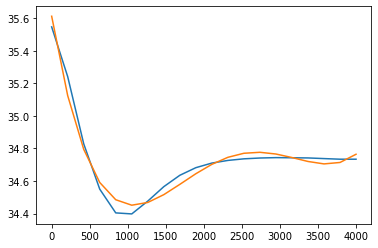

In [27]:
def func(x,a,b,c):
    return a * x**2 + b * x + c
def func(x,a,b,c,d):
    return a * x**3 + b * x**2 + c * x + d 
def func(x,a,b,c,d,e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e
# def func(x,a,b,c,d):
#     return a * np.exp(-x) + b * x**2 + c * x + d
y = SALT_WOA_SO_xmean_interp
popt,pcov = curve_fit(func,y.depth,y.isel(lat=-1))
plt.plot(y.depth,y.isel(lat=-1))
plt.plot(y.depth,func(y.depth,*popt))

In [9]:
# ___ EXPAND ALONG ZONAL DIMENSION ___ #

# Extend zonal mean interpolated section to 3D grid
# Create 'dummy' DataArray with longitude dimension of correct length
Xr = xr.DataArray(np.ones(X1d.shape),coords=[X1d],dims=['lon'])
# Broadcast lat-depth arrays of SALT and DEPTH along longitude
SALT_WOA_SO_xmean_interp_3D = Xr*SALT_WOA_SO_xmean_interp
PTEMP_WOA_SO_xmean_interp_3D = Xr*PTEMP_WOA_SO_xmean_interp

# Save 3D grid to initialization file


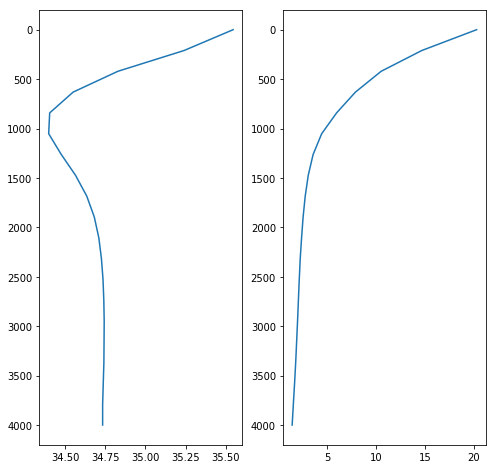

In [112]:
# ___ NORTHERN BOUNDARY PROFILE ___ #

# Isolate northern profile (for COORD_CONFIG file and SPONGE)
SALT_WOA_SO_xmean_interp_NORTH = SALT_WOA_SO_xmean_interp.sel(lat=SOUTHLAT+LENLAT,method='nearest')
PTEMP_WOA_SO_xmean_interp_NORTH = PTEMP_WOA_SO_xmean_interp.sel(lat=SOUTHLAT+LENLAT,method='nearest')

# Plot Northern boundary zonal mean interpolated profile
fig,ax = plt.subplots(figsize=(8,8),ncols=2)
im = ax[0].plot(SALT_WOA_SO_xmean_interp_NORTH,SALT_WOA_SO_xmean_interp_NORTH.depth)
im = ax[1].plot(PTEMP_WOA_SO_xmean_interp_NORTH,PTEMP_WOA_SO_xmean_interp_NORTH.depth)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

# Save profile to initialization file


# Analytic
Analytic function for T and S profile (also as a function of latitude)  
Use WOA data to fit parameters

__NOTE__: An analytic expression for salinity is not straightforward, so at present simply set to constant value

In [3]:
# ___ IMPORT AND PLOT DATA ___ #

# Import WOA .nc files
rootdir = '/work/gam/WOA/'
filename_SALT = 'woa18_decav_s00_01.nc'
filename_PTEMP = 'woa18_decav_t00_01.nc'

SALT_WOA = xr.open_dataset(rootdir+filename_SALT,decode_times=False)
PTEMP_WOA = xr.open_dataset(rootdir+filename_PTEMP,decode_times=False)

# Take climatological annual mean (*_an), isolate Southern Ocean and take zonal mean
SALT_WOA_SO_xmean = SALT_WOA.s_an.sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT),time=4326).mean(dim='lon')
PTEMP_WOA_SO_xmean = PTEMP_WOA.t_an.sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT),time=4326).mean(dim='lon')

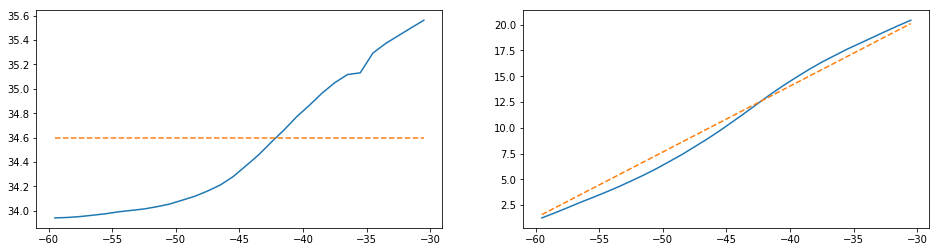

In [4]:
# ___ SURFACE ___ #

# Plot zonal mean surface T, S as a function of latitude
fig,ax = plt.subplots(figsize=(16,4),ncols=2)
im=ax[0].plot(SALT_WOA_SO_xmean.lat, SALT_WOA_SO_xmean.sel(depth=0.0))
im=ax[1].plot(PTEMP_WOA_SO_xmean.lat, PTEMP_WOA_SO_xmean.sel(depth=0.0))

# Analytic function of surface T as a function of latitude
# First order polynomial
y = PTEMP_WOA_SO_xmean.lat
Ts = PTEMP_WOA_SO_xmean.sel(lat=SOUTHLAT,depth=0,method='nearest')
Tn = PTEMP_WOA_SO_xmean.sel(lat=SOUTHLAT+LENLAT,depth=0,method='nearest')
A = (Tn-Ts)/LENLAT
B = Ts - SOUTHLAT*A
T_surf = A*y+B

ax[1].plot(y,T_surf,linestyle='--')

# Analytic function of surface S as a function of latitude
# 2nd order polynomial
y = SALT_WOA_SO_xmean.lat
ys = SOUTHLAT
yn = SOUTHLAT+LENLAT
# Boundary conditions
Ss = SALT_WOA_SO_xmean.sel(lat=ys,depth=0,method='nearest')
Sn = SALT_WOA_SO_xmean.sel(lat=yn,depth=0,method='nearest')
dSs = 0.0 # Prescribe S gradient at southern boundary

A = (Ss-Sn-dSs*(ys-yn))/(ys*yn-yn**2)
B = dSs-A*ys
C = Ss-dSs*ys

S_surf = A*y**2 + B*y + C

### PLACE HOLDER - CONSTANT S ###
Sref = 34.6;
S_surf = xr.DataArray(Sref*np.ones(S_surf.shape),coords=[y],dims=['lat'])

ax[0].plot(y,S_surf,linestyle='--')


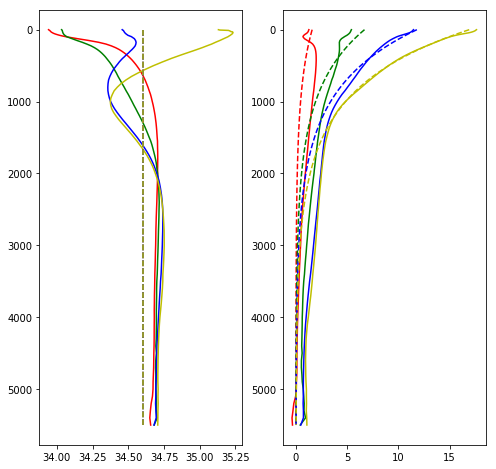

In [5]:
# ___ PROFILE ___ #

# Analytic expression
# S
z = SALT_WOA_SO_xmean.depth
zr = xr.DataArray(np.ones(z.shape),coords=[z],dims=['depth'])
S = S_surf.transpose()*zr
# T
z = PTEMP_WOA_SO_xmean.depth
z0 = 800
T = T_surf*np.exp(-z/z0)

# Plot zonal mean T, S profiles
fig,ax = plt.subplots(figsize=(8,8),ncols=2)
ax[0].set_prop_cycle(cycler('color',['r','g','b','y']))
ax[1].set_prop_cycle(cycler('color',['r','g','b','y']))
im=ax[0].plot(SALT_WOA_SO_xmean.sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT,8)),SALT_WOA.depth)
im=ax[1].plot(PTEMP_WOA_SO_xmean.sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT,8)),PTEMP_WOA.depth)
im = ax[1].plot(T.transpose().sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT,8)),z,linestyle='--')
im = ax[0].plot(S.transpose().sel(lat=slice(SOUTHLAT,SOUTHLAT+LENLAT,8)),z,linestyle='--')
ax[0].invert_yaxis()
ax[1].invert_yaxis()


In [6]:
# ___ CREATE 3D GRID ___#

# Interpolate onto latitude-z* grid of model configuration
S_interp = S.interp(lat=Y1d,depth=Z,)
T_interp = T.interp(lat=Y1d,depth=Z,)

# Broadcast in 3rd dimension
Xr = xr.DataArray(np.ones(X1d.shape),coords=[X1d],dims=['lon'])
# Broadcast lat-depth arrays of SALT and DEPTH along longitude
S_interp_3D = Xr*S_interp
T_interp_3D = Xr*T_interp

# Take northern-most profiles
S_north = S_interp_3D.sel(lat=SOUTHLAT+LENLAT,method='nearest')
T_north = T_interp_3D.sel(lat=SOUTHLAT+LENLAT,method='nearest')

# Isolate single northern profile
S_prof = S_interp.sel(lat=SOUTHLAT+LENLAT,method='nearest')
T_prof = T_interp.sel(lat=SOUTHLAT+LENLAT,method='nearest')

# Select T, S at the surface
S_surf = S_interp_3D.sel(depth=0,method='nearest')
T_surf = T_interp_3D.sel(depth=0,method='nearest')


In [7]:
# ___ SAVE TO NETCDF ___ #

# Merge all arrays to one DataSet
S_interp.name='S_interp'
T_interp.name='T_interp'
S_interp_3D.name = 'S_interp_3D'
T_interp_3D.name = 'T_interp_3D'
S_north.name = 'S_north'
T_north.name = 'T_north'
S_prof.name = 'S_prof'
T_prof.name = 'T_prof'
S_surf.name = 'S_surf'
T_surf.name = 'T_surf'
TS = xr.merge([S_interp,T_interp,S_interp_3D,T_interp_3D,S_north,T_north,S_prof,T_prof,SSS,T_surf])
# Transpose
TS = TS.transpose('depth','lat','lon')
# Save to netcdf
rootdir = '/work/gam/MOM6/initialization/'
config = 'channel'
filename = 'ts_analytic.nc'
TS.to_netcdf(rootdir+config+'/'+filename)

In [17]:
print(TS)

<xarray.Dataset>
Dimensions:      (depth: 20, lat: 20, lon: 100)
Coordinates:
  * lat          (lat) float64 -59.25 -57.75 -56.25 ... -33.75 -32.25 -30.75
  * depth        (depth) float64 0.0 210.5 421.1 ... 3.579e+03 3.789e+03 4e+03
    time         float32 4326.0
  * lon          (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 95.5 96.5 97.5 98.5 99.5
Data variables:
    S_interp     (depth, lat) float64 34.6 34.6 34.6 34.6 ... 34.6 34.6 34.6
    T_interp     (depth, lat) float64 1.741 2.699 3.657 ... 0.1215 0.1279 0.1344
    S_interp_3D  (depth, lat, lon) float64 34.6 34.6 34.6 ... 34.6 34.6 34.6
    T_interp_3D  (depth, lat, lon) float64 1.741 1.741 1.741 ... 0.1344 0.1344
    S_north      (depth, lon) float64 34.6 34.6 34.6 34.6 ... 34.6 34.6 34.6
    T_north      (depth, lon) float64 19.95 19.95 19.95 ... 0.1344 0.1344 0.1344
    S_prof       (depth) float64 34.6 34.6 34.6 34.6 ... 34.6 34.6 34.6 34.6
    T_prof       (depth) float64 19.95 15.33 11.78 9.061 ... 0.2278 0.175 0.1344
